Loaded: test3_haar - 1057 frames
Loaded: test1_yolo - 445 frames
Loaded: test1_ssd - 500 frames
Loaded: test3_yolov8 - 1057 frames
Loaded: test2_yolo - 479 frames
Loaded: test3_mobilenet - 1057 frames
Loaded: test1_mobilenet - 500 frames
Loaded: test1_yolo - 111 frames
Loaded: test1_yolov8 - 500 frames
Loaded: test1_haar - 500 frames
Loaded: test2_yolov8 - 479 frames
Loaded: test3_yolo - 1057 frames
Loaded: test2_haar - 479 frames
Loaded: test2_yolov5 - 479 frames
Loaded: test3_yolo - 1057 frames
Loaded: test2_ssd - 479 frames
Loaded: test2_yolo - 479 frames
Loaded: test3_yolov5 - 1057 frames
Loaded: test3_ssd - 1057 frames
Loaded: test1_yolov5 - 500 frames
Loaded: test1_yolo - 500 frames
Loaded: test2_mobilenet - 479 frames
Loaded: test1_yolov5 - 500 frames
Loaded: test1_yolo - 500 frames
Loaded: test1_mobilenet - 500 frames

Total experiments loaded: 18
Total frames: 12216

Summary Statistics -
                    fps                        det_time_ms                \
              

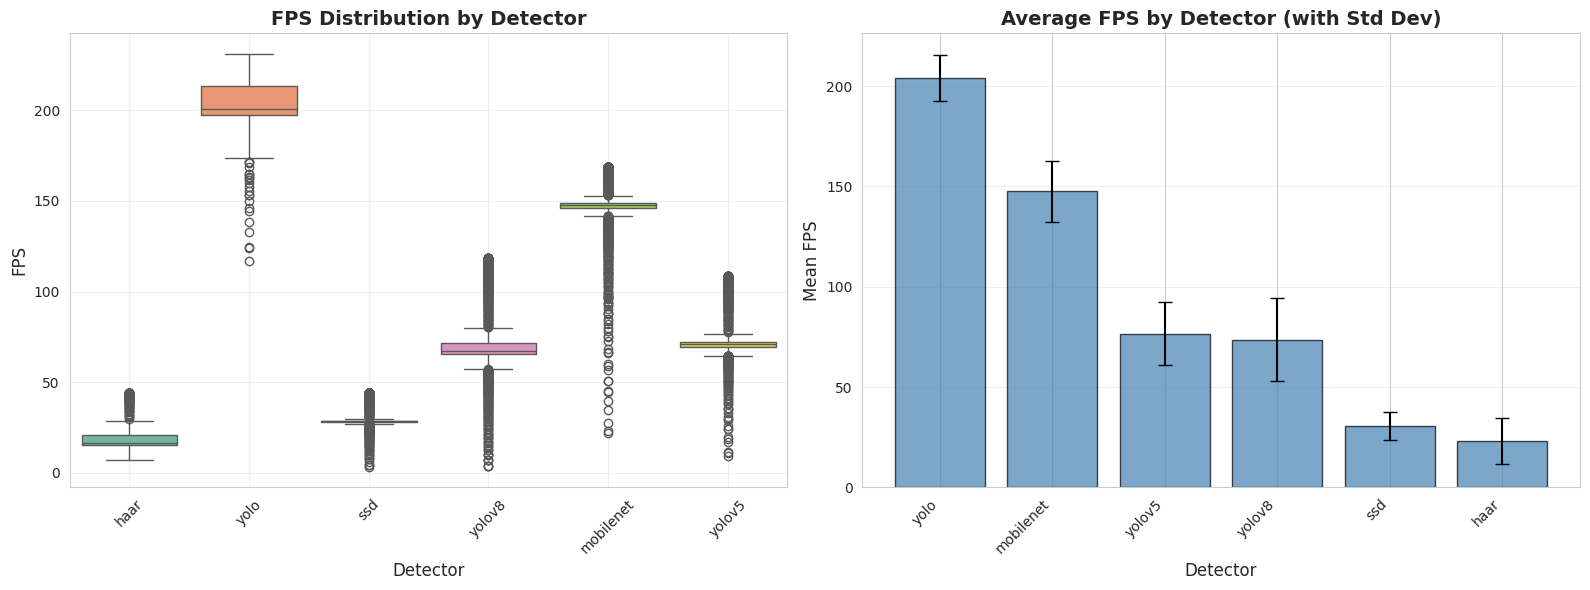

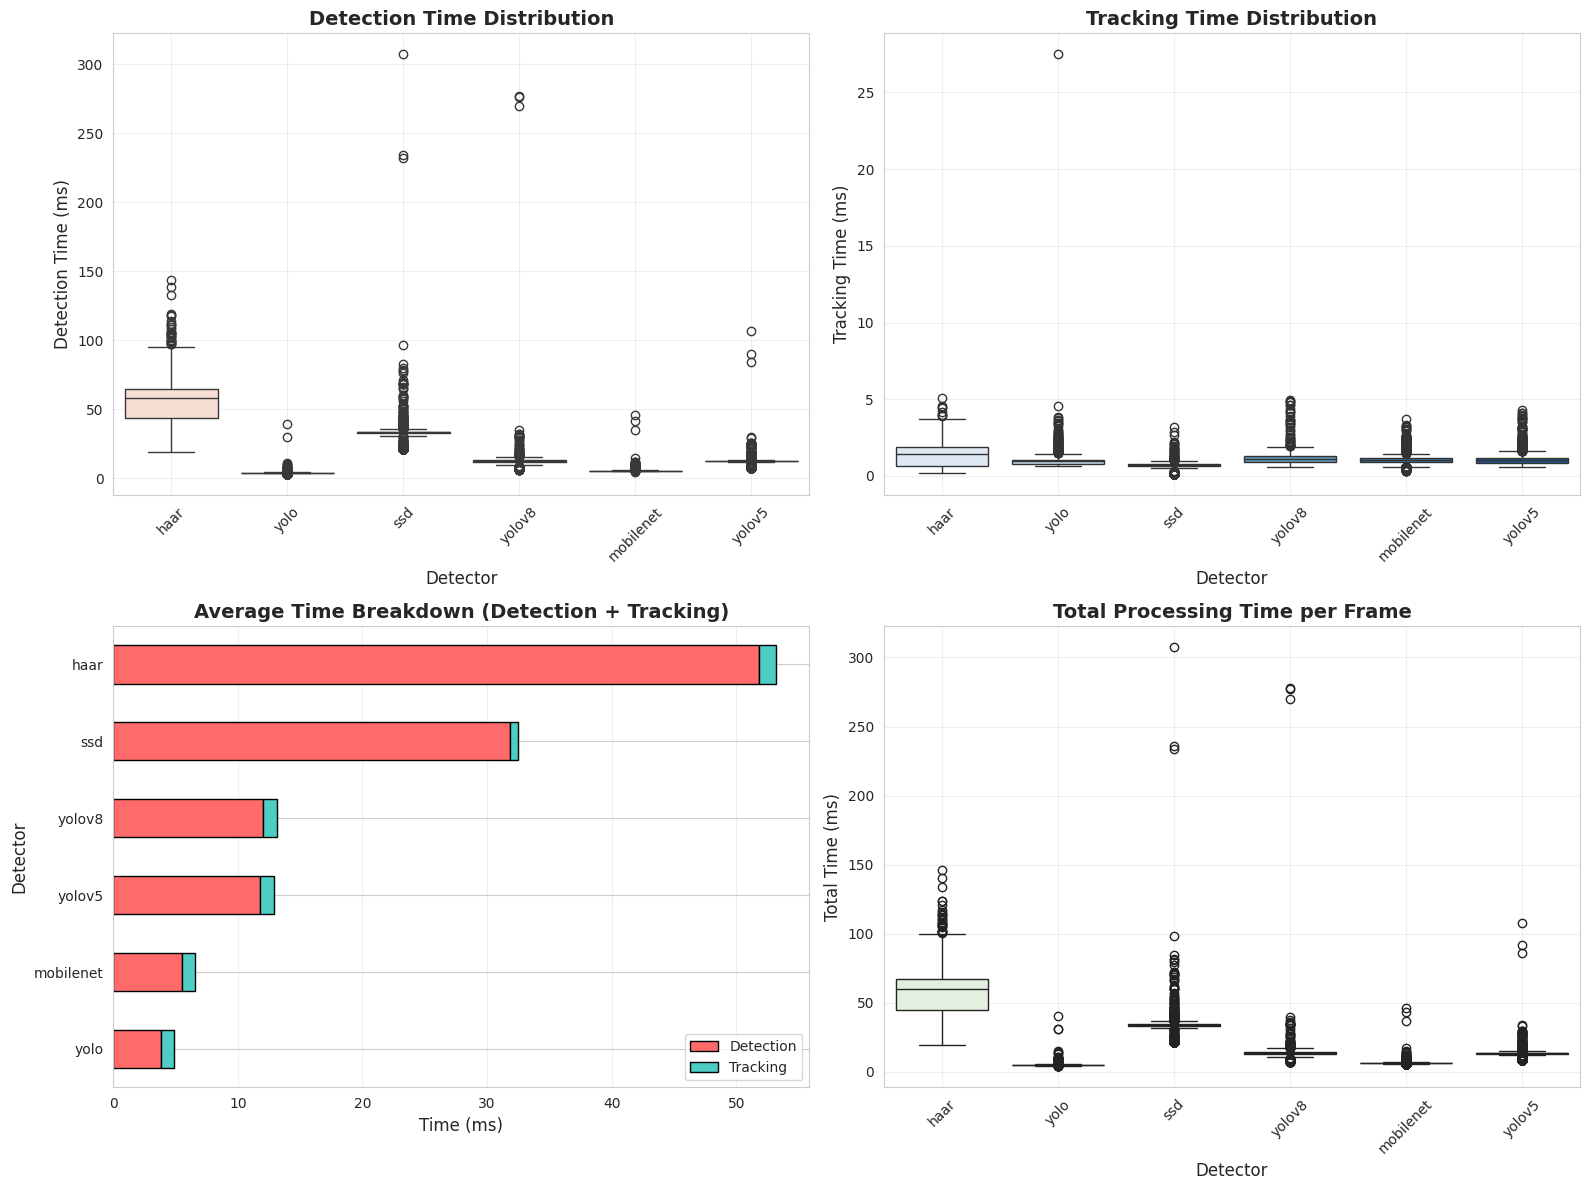

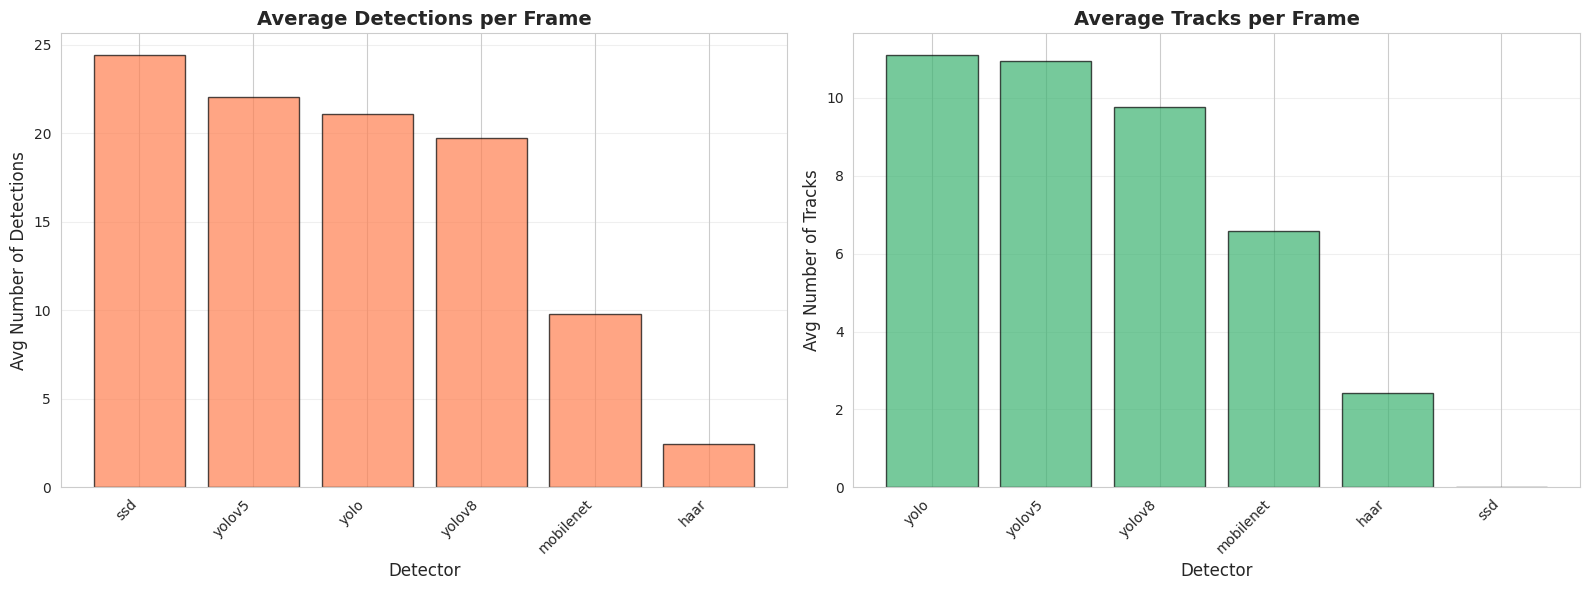

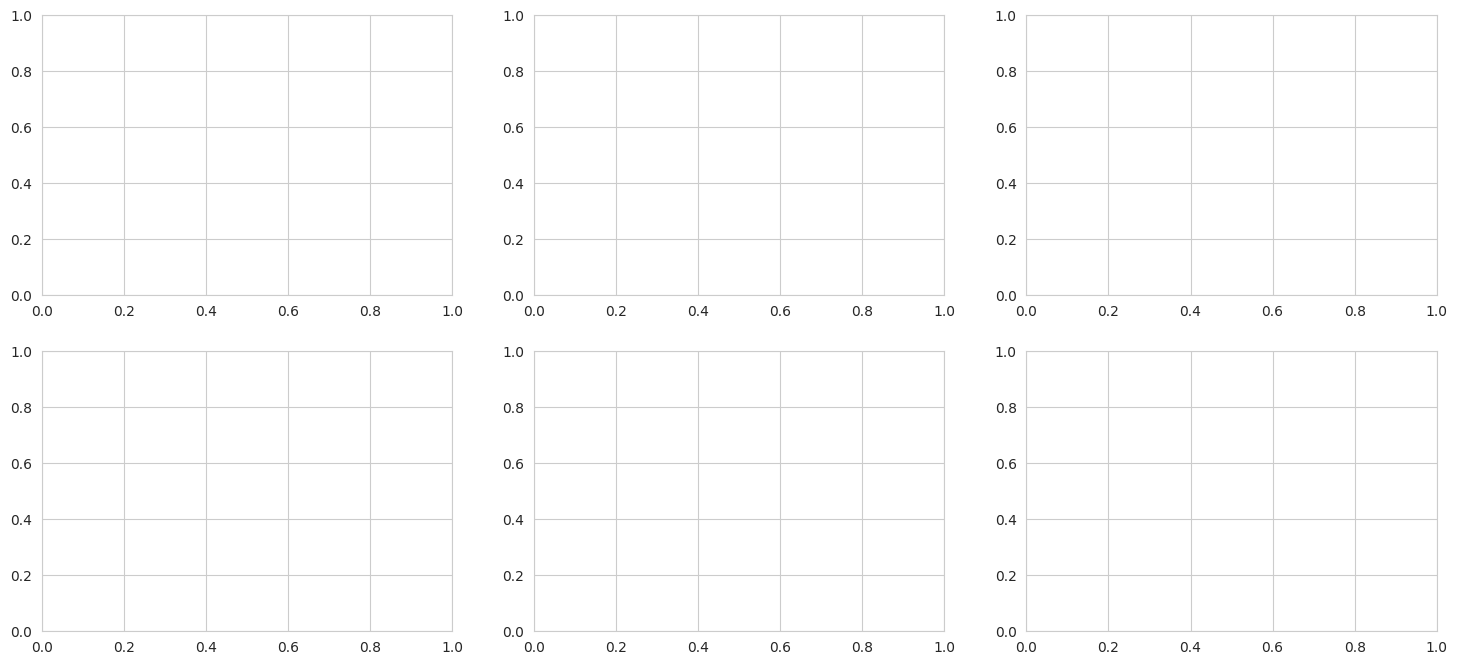

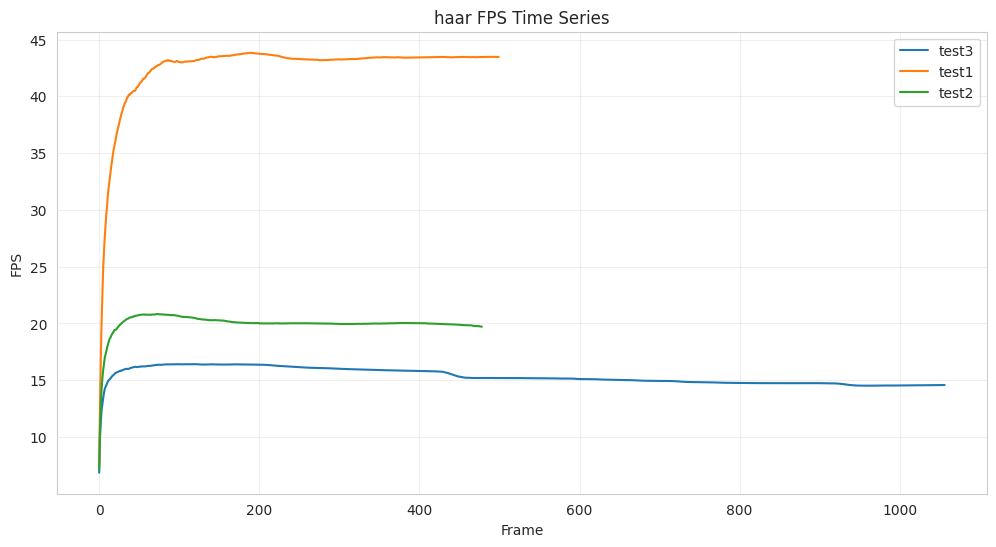

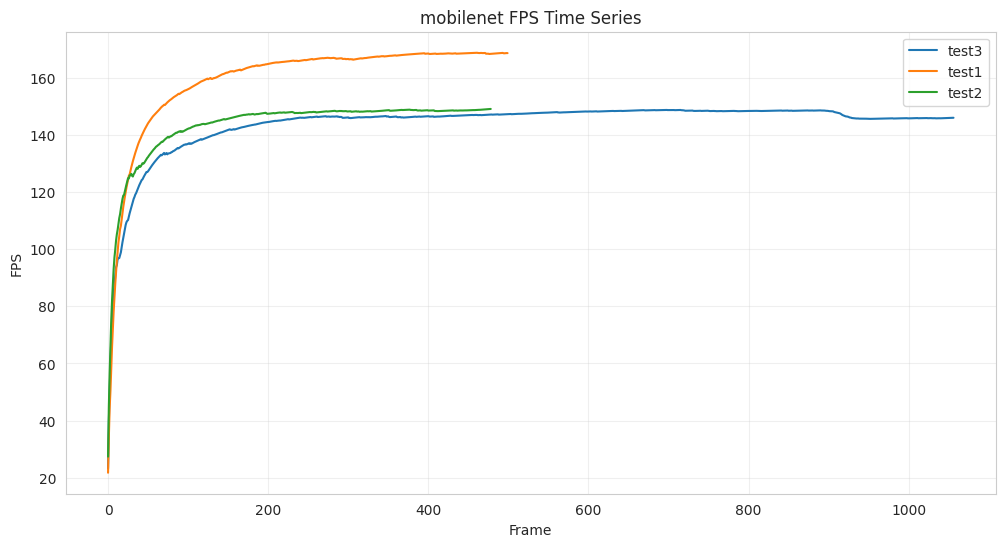

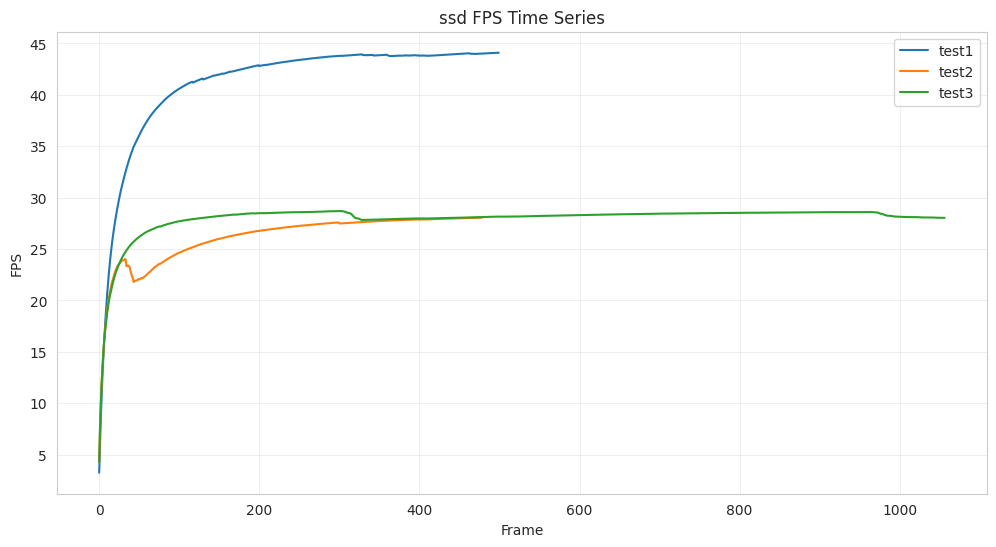

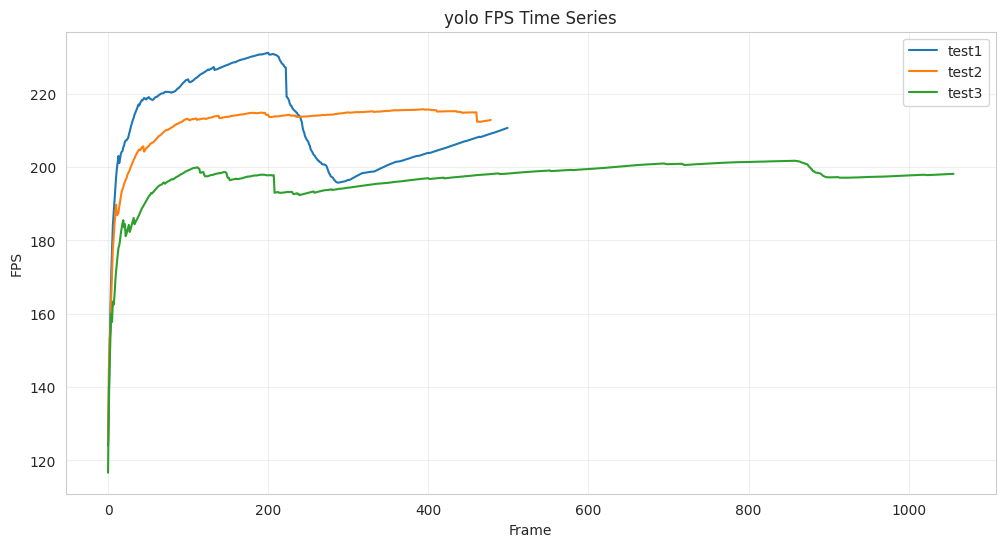

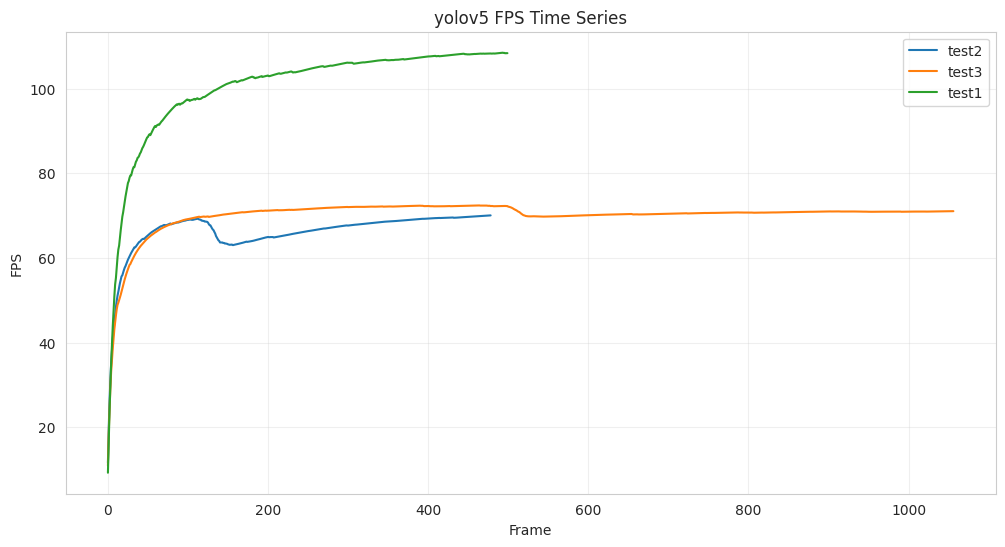

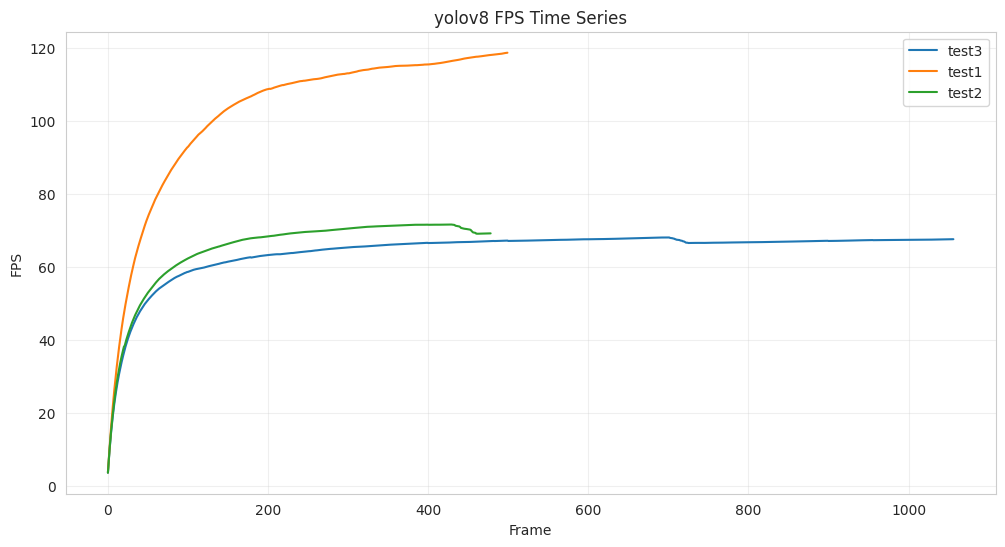

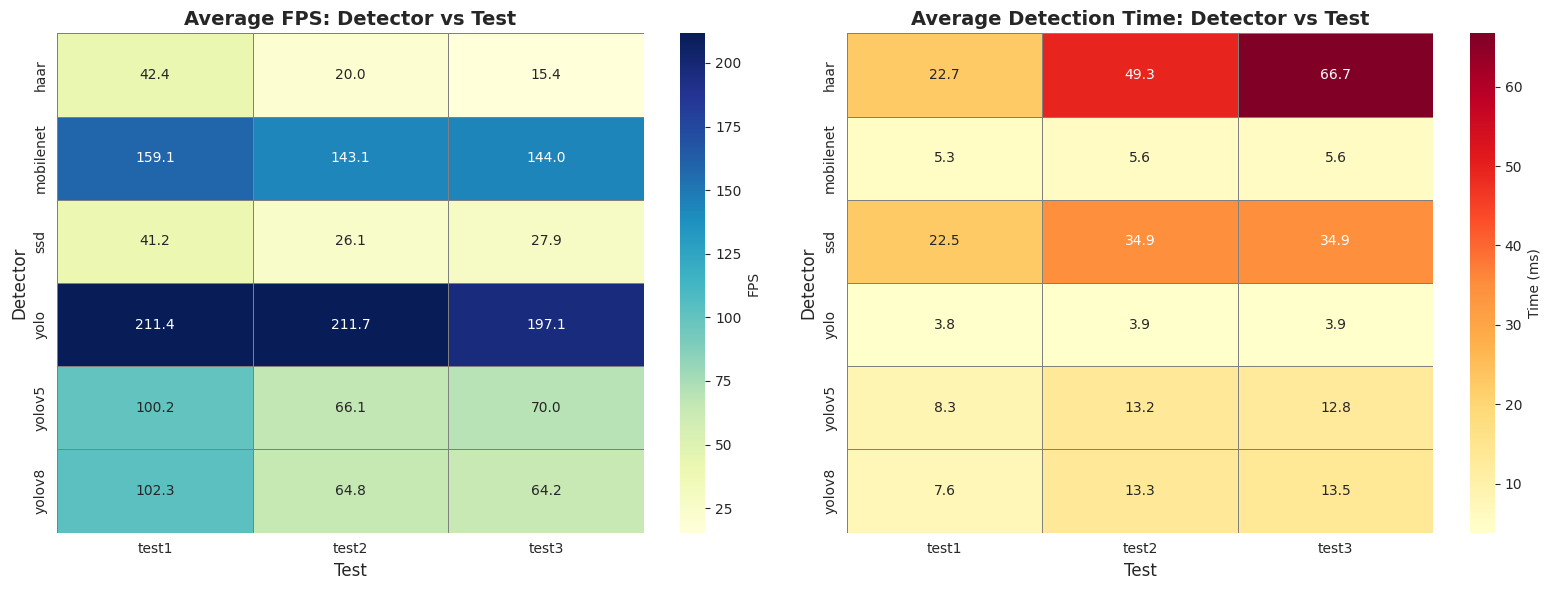

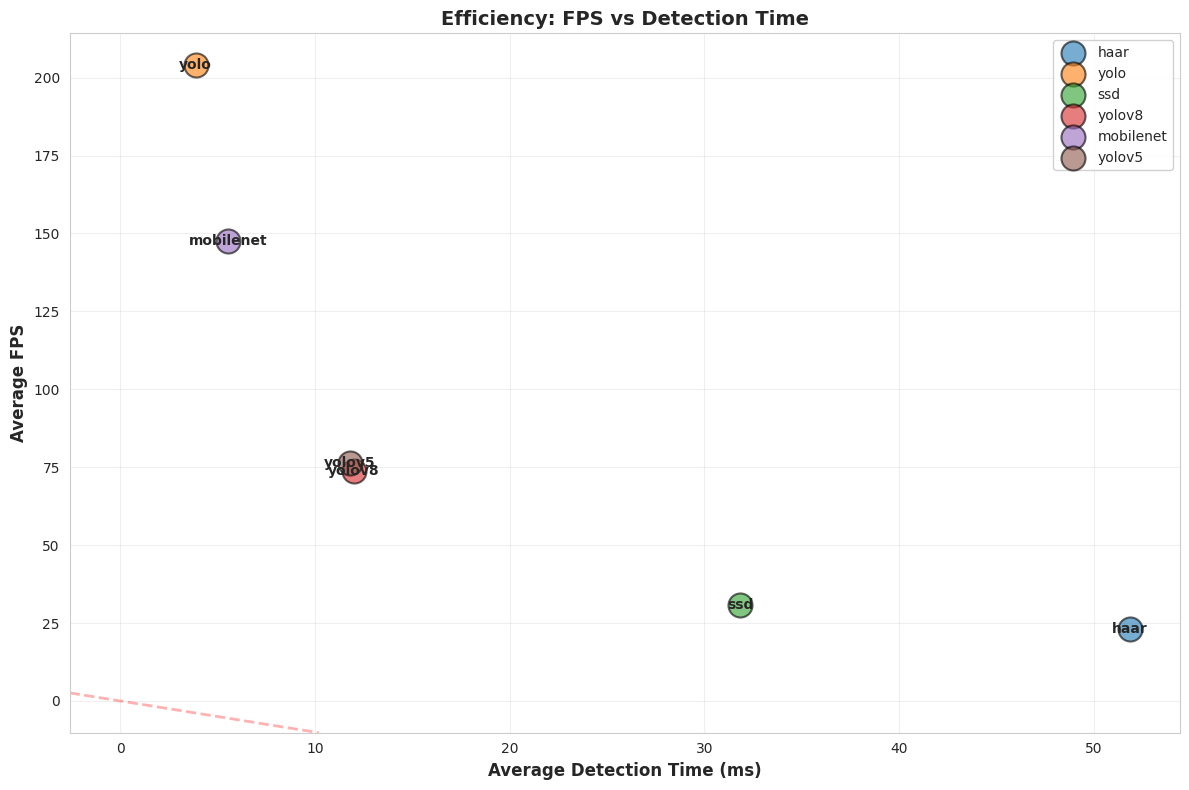

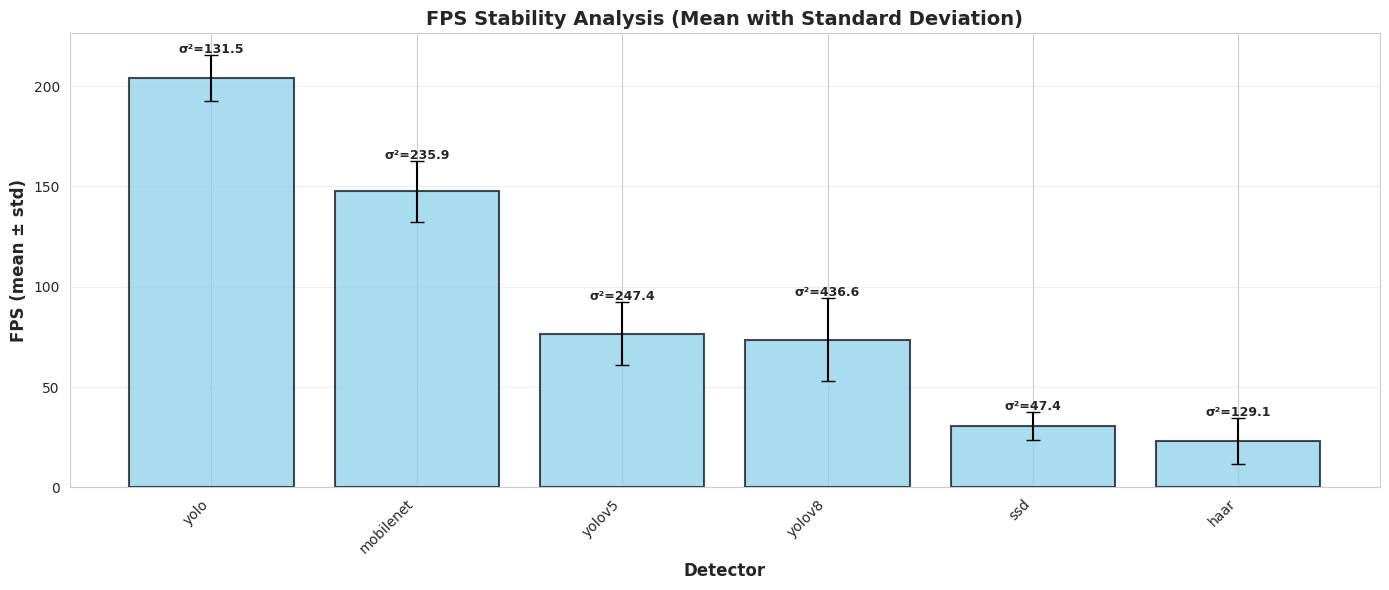

Summary report saved to 'detector_performance_summary.csv'

Detector Performance Ranking :
           fps_mean  det_time_ms_mean  trk_time_ms_mean  total_time_ms_mean
detector                                                                   
yolo         204.02              3.88              1.01                4.89
mobilenet    147.48              5.54              1.05                6.59
yolov5        76.50             11.81              1.12               12.93
yolov8        73.70             12.01              1.14               13.15
ssd           30.75             31.84              0.63               32.47
haar          23.10             51.83              1.36               53.19


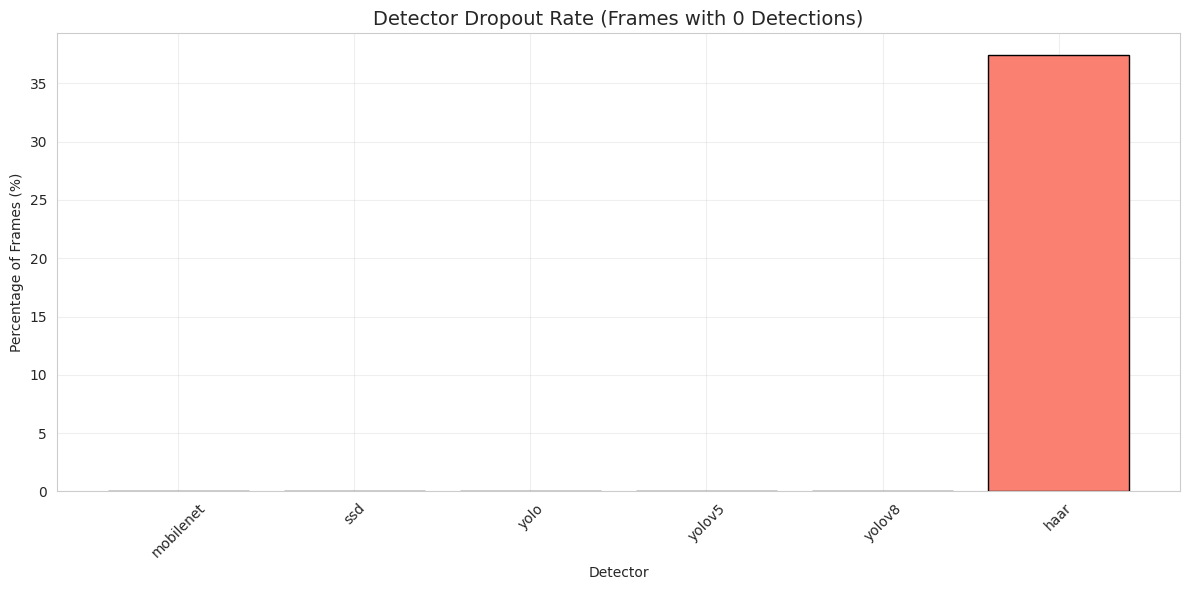


Dropout % by Detector:
 detector
mobilenet     0.000000
ssd           0.000000
yolo          0.000000
yolov5        0.000000
yolov8        0.000000
haar         37.426326
Name: num_dets, dtype: float64


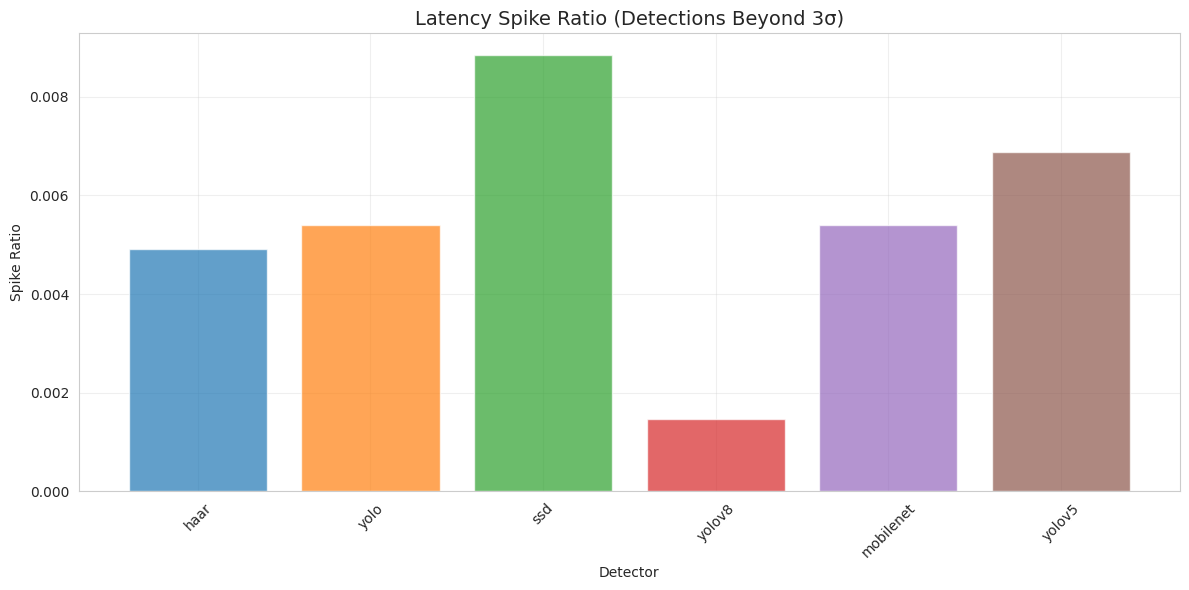

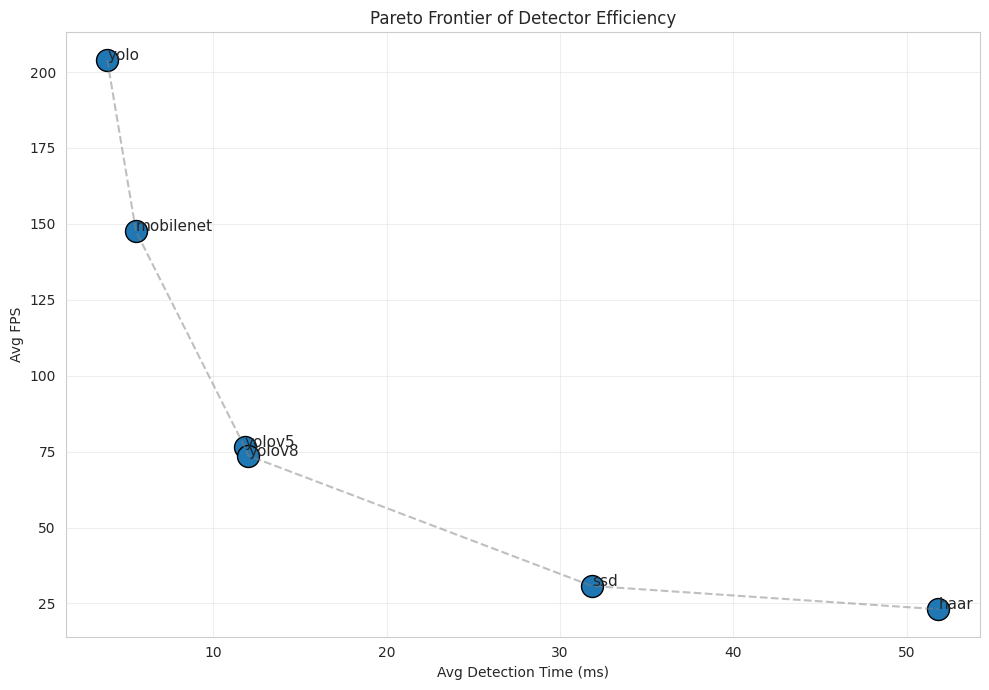

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

# Create analysis_plots folder (same logic as tracker pipeline)
if Path("outputs").exists():
    BASE = Path("outputs")
elif Path("deepsort/AI-Camera/outputs").exists():
    BASE = Path("deepsort/AI-Camera/outputs")
else:
    raise RuntimeError("Cannot find outputs directory")

PLOT_DIR = BASE / "analysis_plots"
PLOT_DIR.mkdir(exist_ok=True, parents=True)


def save_fig(fig, filename):
    """Save AND show each plot separately, then close."""
    fig.savefig(PLOT_DIR / filename, dpi=180, bbox_inches="tight")
    plt.show()
    plt.close(fig)


# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10


def load_frame_logs(base_dir="outputs"):
    """
    Load all frame log JSON files from the outputs directory.
    Returns a dictionary of DataFrames keyed by (test_name, detector).
    """
    frame_logs = {}
    json_files = glob.glob(f"{base_dir}/*_frame_log.json")

    for json_file in json_files:
        filename = Path(json_file).stem
        # Parse filename: test1_yolov8_tracked_20251118-184637_frame_log
        parts = filename.split("_")
        test_name = parts[0]  # e.g., 'test1'
        detector = parts[1]  # e.g., 'yolov8', 'haar', 'mobilenet', etc.

        with open(json_file, "r") as f:
            data = json.load(f)

        df = pd.DataFrame(data)
        df["test"] = test_name
        df["detector"] = detector

        key = f"{test_name}_{detector}"
        frame_logs[key] = df

        print(f"Loaded: {key} - {len(df)} frames")

    return frame_logs


# Load all data
frame_logs = load_frame_logs()

# Combine into single DataFrame for easier analysis
all_data = pd.concat(frame_logs.values(), ignore_index=True)
print(f"\nTotal experiments loaded: {len(frame_logs)}")
print(f"Total frames: {len(all_data)}")


def compute_summary_stats(df):
    """Compute summary statistics for each detector across all tests."""
    summary = (
        df.groupby(["detector", "test"])
        .agg(
            {
                "fps": ["mean", "std", "min", "max"],
                "det_time_ms": ["mean", "std", "min", "max"],
                "trk_time_ms": ["mean", "std", "min", "max"],
                "num_dets": ["mean", "sum"],
                "num_tracks": ["mean", "sum"],
            }
        )
        .round(2)
    )

    return summary


# Compute and display summary
summary_stats = compute_summary_stats(all_data)
print("\nSummary Statistics -")
print(summary_stats)

# Overall detector performance (averaged across all tests)
overall_summary = (
    all_data.groupby("detector")
    .agg(
        {
            "fps": "mean",
            "det_time_ms": "mean",
            "trk_time_ms": "mean",
            "num_dets": "mean",
            "num_tracks": "mean",
        }
    )
    .round(2)
    .sort_values("fps", ascending=False)
)

print("\nOverall Detector Performance (Avg across all tests) -")
print(overall_summary)

# FPS comparison across detectors and tests
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot for FPS distribution
sns.boxplot(
    data=all_data,
    x="detector",
    y="fps",
    hue="detector",
    palette="Set2",
    legend=False,
    ax=axes[0],
)
axes[0].set_title("FPS Distribution by Detector", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Detector", fontsize=12)
axes[0].set_ylabel("FPS", fontsize=12)
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(True, alpha=0.3)

# Bar plot for average FPS with error bars
fps_stats = all_data.groupby("detector")["fps"].agg(["mean", "std"])
fps_stats = fps_stats.sort_values("mean", ascending=False)
axes[1].bar(
    range(len(fps_stats)),
    fps_stats["mean"],
    yerr=fps_stats["std"],
    capsize=5,
    alpha=0.7,
    color="steelblue",
    edgecolor="black",
)
axes[1].set_xticks(range(len(fps_stats)))
axes[1].set_xticklabels(fps_stats.index, rotation=45, ha="right")
axes[1].set_title(
    "Average FPS by Detector (with Std Dev)", fontsize=14, fontweight="bold"
)
axes[1].set_xlabel("Detector", fontsize=12)
axes[1].set_ylabel("Mean FPS", fontsize=12)
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
save_fig(fig, "global_fps_boxplot.png")

# Time breakdown: Detection vs Tracking
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Detection time comparison
sns.boxplot(
    data=all_data,
    x="detector",
    y="det_time_ms",
    hue="detector",
    palette="Reds",
    legend=False,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Detection Time Distribution", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Detector", fontsize=12)
axes[0, 0].set_ylabel("Detection Time (ms)", fontsize=12)
axes[0, 0].tick_params(axis="x", rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Tracking time comparison
sns.boxplot(
    data=all_data,
    x="detector",
    y="trk_time_ms",
    hue="detector",
    palette="Blues",
    legend=False,
    ax=axes[0, 1],
)
axes[0, 1].set_title("Tracking Time Distribution", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Detector", fontsize=12)
axes[0, 1].set_ylabel("Tracking Time (ms)", fontsize=12)
axes[0, 1].tick_params(axis="x", rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Stacked bar chart: avg detection + tracking time
time_breakdown = all_data.groupby("detector")[["det_time_ms", "trk_time_ms"]].mean()
time_breakdown = time_breakdown.sort_values("det_time_ms", ascending=True)
time_breakdown.plot(
    kind="barh",
    stacked=True,
    ax=axes[1, 0],
    color=["#ff6b6b", "#4ecdc4"],
    edgecolor="black",
)
axes[1, 0].set_title(
    "Average Time Breakdown (Detection + Tracking)", fontsize=14, fontweight="bold"
)
axes[1, 0].set_xlabel("Time (ms)", fontsize=12)
axes[1, 0].set_ylabel("Detector", fontsize=12)
axes[1, 0].legend(["Detection", "Tracking"], loc="lower right")
axes[1, 0].grid(True, alpha=0.3, axis="x")

# Total processing time per frame
all_data["total_time_ms"] = all_data["det_time_ms"] + all_data["trk_time_ms"]
sns.boxplot(
    data=all_data,
    x="detector",
    y="total_time_ms",
    hue="detector",
    palette="Greens",
    legend=False,
    ax=axes[1, 1],
)
axes[1, 1].set_title("Total Processing Time per Frame", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Detector", fontsize=12)
axes[1, 1].set_ylabel("Total Time (ms)", fontsize=12)
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
# Save each subplot independently
save_fig(axes[0, 0].get_figure(), "global_det_time_boxplot.png")
save_fig(axes[0, 1].get_figure(), "global_trk_time_boxplot.png")
save_fig(axes[1, 0].get_figure(), "global_time_breakdown_stacked.png")
save_fig(axes[1, 1].get_figure(), "global_total_latency_boxplot.png")
plt.close(fig)


# Number of detections and tracks
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average number of detections per frame
det_counts = (
    all_data.groupby("detector")["num_dets"].mean().sort_values(ascending=False)
)
axes[0].bar(
    range(len(det_counts)),
    det_counts.values,
    color="coral",
    edgecolor="black",
    alpha=0.7,
)
axes[0].set_xticks(range(len(det_counts)))
axes[0].set_xticklabels(det_counts.index, rotation=45, ha="right")
axes[0].set_title("Average Detections per Frame", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Detector", fontsize=12)
axes[0].set_ylabel("Avg Number of Detections", fontsize=12)
axes[0].grid(True, alpha=0.3, axis="y")

# Average number of tracks per frame
track_counts = (
    all_data.groupby("detector")["num_tracks"].mean().sort_values(ascending=False)
)
axes[1].bar(
    range(len(track_counts)),
    track_counts.values,
    color="mediumseagreen",
    edgecolor="black",
    alpha=0.7,
)
axes[1].set_xticks(range(len(track_counts)))
axes[1].set_xticklabels(track_counts.index, rotation=45, ha="right")
axes[1].set_title("Average Tracks per Frame", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Detector", fontsize=12)
axes[1].set_ylabel("Avg Number of Tracks", fontsize=12)
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
save_fig(fig, "global_detections_tracks.png")

# Time series for each detector (showing FPS over frames)
detectors = all_data["detector"].unique()
n_detectors = len(detectors)
cols = 3
rows = (n_detectors + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten() if n_detectors > 1 else [axes]

for detector in sorted(detectors):
    fig = plt.figure(figsize=(12, 6))
    for test in all_data[all_data.detector == detector]["test"].unique():
        df = all_data[(all_data.detector == detector) & (all_data.test == test)]
        plt.plot(df["frame_id"], df["fps"], label=test)

    plt.title(f"{detector} FPS Time Series")
    plt.xlabel("Frame")
    plt.ylabel("FPS")
    plt.legend()
    plt.grid(True, alpha=0.3)
    save_fig(fig, f"{test}_{detector}_timeseries.png")


# Heatmap showing performance metrics across tests and detectors
pivot_fps = all_data.pivot_table(
    values="fps", index="detector", columns="test", aggfunc="mean"
)
pivot_det_time = all_data.pivot_table(
    values="det_time_ms", index="detector", columns="test", aggfunc="mean"
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# FPS heatmap
sns.heatmap(
    pivot_fps,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    ax=axes[0],
    cbar_kws={"label": "FPS"},
    linewidths=0.5,
    linecolor="gray",
)
axes[0].set_title("Average FPS: Detector vs Test", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Test", fontsize=12)
axes[0].set_ylabel("Detector", fontsize=12)

# Detection time heatmap
sns.heatmap(
    pivot_det_time,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    ax=axes[1],
    cbar_kws={"label": "Time (ms)"},
    linewidths=0.5,
    linecolor="gray",
)
axes[1].set_title(
    "Average Detection Time: Detector vs Test", fontsize=14, fontweight="bold"
)
axes[1].set_xlabel("Test", fontsize=12)
axes[1].set_ylabel("Detector", fontsize=12)

plt.tight_layout()
save_fig(fig, "global_detector_heatmaps.png")

# Efficiency: FPS vs Detection Time scatter
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for detector in all_data["detector"].unique():
    detector_data = all_data[all_data["detector"] == detector]
    avg_fps = detector_data["fps"].mean()
    avg_det_time = detector_data["det_time_ms"].mean()

    ax.scatter(
        avg_det_time,
        avg_fps,
        s=300,
        alpha=0.6,
        label=detector,
        edgecolor="black",
        linewidth=1.5,
    )
    ax.annotate(
        detector,
        (avg_det_time, avg_fps),
        fontsize=10,
        ha="center",
        va="center",
        fontweight="bold",
    )

ax.set_xlabel("Average Detection Time (ms)", fontsize=12, fontweight="bold")
ax.set_ylabel("Average FPS", fontsize=12, fontweight="bold")
ax.set_title("Efficiency: FPS vs Detection Time", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(loc="best", framealpha=0.9)

# Add efficiency line (lower-left to upper-right is better)
ax.axline(
    (0, 0),
    slope=-1,
    color="red",
    linestyle="--",
    alpha=0.3,
    linewidth=2,
    label="Efficiency Trend",
)

plt.tight_layout()
save_fig(fig, "global_efficiency_scatter.png")

# Analyze stability (variance in FPS)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

fps_variance = all_data.groupby("detector")["fps"].agg(["mean", "std", "var"])
fps_variance = fps_variance.sort_values("mean", ascending=False)

x_pos = np.arange(len(fps_variance))
ax.bar(
    x_pos,
    fps_variance["mean"],
    yerr=fps_variance["std"],
    capsize=5,
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
    linewidth=1.5,
)
ax.set_xticks(x_pos)
ax.set_xticklabels(fps_variance.index, rotation=45, ha="right")
ax.set_ylabel("FPS (mean ± std)", fontsize=12, fontweight="bold")
ax.set_xlabel("Detector", fontsize=12, fontweight="bold")
ax.set_title(
    "FPS Stability Analysis (Mean with Standard Deviation)",
    fontsize=14,
    fontweight="bold",
)
ax.grid(True, alpha=0.3, axis="y")

# Annotate variance values
for i, (idx, row) in enumerate(fps_variance.iterrows()):
    ax.text(
        i,
        row["mean"] + row["std"] + 1,
        f"σ²={row['var']:.1f}",
        ha="center",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
save_fig(fig, "global_fps_stability.png")

# Create comprehensive summary report
summary_report = (
    all_data.groupby("detector")
    .agg(
        {
            "fps": ["mean", "std", "min", "max"],
            "det_time_ms": ["mean", "std", "min", "max"],
            "trk_time_ms": ["mean", "std", "min", "max"],
            "num_dets": ["mean", "sum"],
            "num_tracks": ["mean", "sum"],
            "total_time_ms": ["mean", "std"],
        }
    )
    .round(2)
)

summary_report.columns = [
    "_".join(col).strip() for col in summary_report.columns.values
]
summary_report = summary_report.sort_values("fps_mean", ascending=False)

# Save to CSV
summary_report.to_csv("detector_performance_summary.csv")
print("Summary report saved to 'detector_performance_summary.csv'")
print("\nDetector Performance Ranking :")
print(
    summary_report[
        ["fps_mean", "det_time_ms_mean", "trk_time_ms_mean", "total_time_ms_mean"]
    ]
)

# Zero-Detection Frame Analysis (Dropout Rate)
dropout = (
    all_data.groupby("detector")["num_dets"]
    .apply(lambda x: (x == 0).mean() * 100)
    .sort_values()
)

plt.figure(figsize=(12, 6))
plt.bar(dropout.index, dropout.values, color="salmon", edgecolor="black")
plt.title("Detector Dropout Rate (Frames with 0 Detections)", fontsize=14)
plt.ylabel("Percentage of Frames (%)")
plt.xlabel("Detector")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
save_fig(plt.gcf(), "global_dropout_rate.png")

print("\nDropout % by Detector:\n", dropout)

# Latency Spike Analysis
plt.figure(figsize=(12, 6))

for det in all_data["detector"].unique():
    series = all_data[all_data["detector"] == det]["det_time_ms"]
    spike_ratio = np.mean(series > series.mean() + 3 * series.std())
    plt.bar(det, spike_ratio, alpha=0.7)

plt.title("Latency Spike Ratio (Detections Beyond 3σ)", fontsize=14)
plt.ylabel("Spike Ratio")
plt.xlabel("Detector")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
save_fig(plt.gcf(), "global_latency_spike_ratio.png")

# Efficiency Frontier (Pareto Optimal Detectors)
eff = (
    all_data.groupby("detector")[["fps", "det_time_ms"]]
    .mean()
    .sort_values("fps", ascending=False)
)

plt.figure(figsize=(10, 7))
plt.scatter(eff["det_time_ms"], eff["fps"], s=250, edgecolor="black")

for d in eff.index:
    plt.annotate(d, (eff["det_time_ms"][d], eff["fps"][d]), fontsize=11)

# Pareto line
sorted_eff = eff.sort_values("det_time_ms")
plt.plot(sorted_eff["det_time_ms"], sorted_eff["fps"], "--", color="gray", alpha=0.5)

plt.xlabel("Avg Detection Time (ms)")
plt.ylabel("Avg FPS")
plt.title("Pareto Frontier of Detector Efficiency")
plt.grid(alpha=0.3)
plt.tight_layout()
save_fig(plt.gcf(), "global_pareto_efficiency.png")